- 동적메모리 GPU할당

In [66]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2, os, glob

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [67]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_text as text
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd

In [68]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [69]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [70]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))

    print()

    for en in en_examples.numpy():
        print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2024-07-26 05:29:05.519965: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [71]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [72]:
tokenizers = tf.saved_model.load(model_name)

In [73]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [74]:
for en in en_examples.numpy():
    print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [75]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [76]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [77]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [78]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [79]:
BUFFER_SIZE = 20000
BATCH_SIZE = 512

In [80]:
def make_batches(ds):
    return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [81]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [82]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


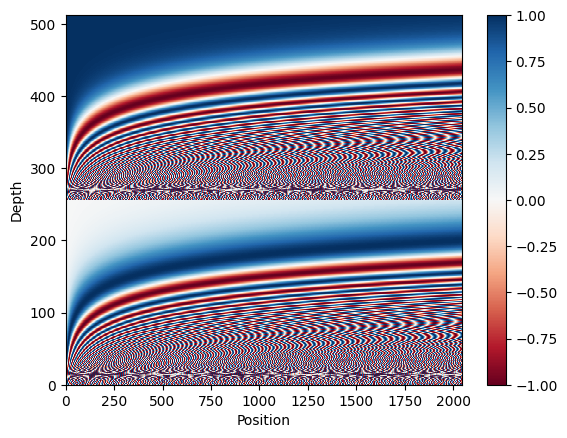

In [83]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [84]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [85]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [86]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [87]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [88]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [89]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [90]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [91]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [92]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [93]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [94]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [95]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

### abRelu 삽입

In [96]:
class abRelu(tf.keras.layers.Layer):
    def __init__(self, initial_a=6.0, initial_b=0.0):
        super(abRelu, self).__init__()
        self.initial_a = initial_a
        self.initial_b = initial_b

    def build(self, input_shape):
        # Create trainable parameters a and b
        self.a = self.add_weight(
            shape=(input_shape[-1],),  # Shape for each feature in the input
            initializer=tf.keras.initializers.Constant(self.initial_a),
            trainable=True,
            name='a'
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),  # Shape for each feature in the input
            initializer=tf.keras.initializers.Constant(self.initial_b),
            trainable=True,
            name='b'
        )
        super(abRelu, self).build(input_shape)

    def call(self, inputs):
        
        return tf.where(inputs >= 0, self.a * (inputs - self.b), 0)

    def get_config(self):
        config = super(abRelu, self).get_config()
        config.update({
            'initial_a': self.initial_a,
            'initial_b': self.initial_b
        })
        return config

In [97]:
def point_wise_feed_forward_network(d_model, dff, initial_a=6.0, initial_b=0.0):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff),  
        abRelu(initial_a=initial_a, initial_b=initial_b),  
        tf.keras.layers.Dense(d_model)  
    ])


In [98]:
sample_ffn = point_wise_feed_forward_network(512, 2048, 1,0)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [99]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, initial_a=6.0, initial_b=0.0, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        
        # Pass initial_a and initial_b to the point_wise_feed_forward_network
        self.ffn = point_wise_feed_forward_network(d_model, dff, initial_a=initial_a, initial_b=initial_b)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


In [100]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    x=tf.random.uniform((64, 43, 512)), training=False, mask=None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [101]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, initial_a=6.0, initial_b=0.0, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        # Pass initial_a and initial_b to the point_wise_feed_forward_network
        self.ffn = point_wise_feed_forward_network(d_model, dff, initial_a=initial_a, initial_b=initial_b)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2


In [102]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    x=tf.random.uniform((64, 50, 512)), enc_output=sample_encoder_layer_output,
    training=False, look_ahead_mask=None, padding_mask=None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [103]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1, initial_a=6.0, initial_b=0.0):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Pass initial_a and initial_b to each EncoderLayer
        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, initial_a=initial_a, initial_b=initial_b, rate=rate)
            for _ in range(num_layers)
        ]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x=x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, d_model)


In [104]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [105]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1, initial_a=6.0, initial_b=0.0):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Pass initial_a and initial_b to each DecoderLayer
        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate=rate, initial_a=initial_a, initial_b=initial_b)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x=x,
                enc_output=enc_output,
                training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )

            attention_weights[f'decoder_layer{i + 1}_block1'] = block1
            attention_weights[f'decoder_layer{i + 1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


In [106]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [107]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1, initial_a=6.0, initial_b=0.0):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            num_layers, d_model, num_heads, dff,
            input_vocab_size, pe_input, rate, initial_a, initial_b
        )

        self.decoder = Decoder(
            num_layers, d_model, num_heads, dff,
            target_vocab_size, pe_target, rate, initial_a, initial_b
        )

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(
            inp, training=training, mask=enc_padding_mask
        )  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output=enc_output, training=training,
            look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask
        )

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask


In [108]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [109]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [110]:
# 학습률 스케줄러 정의
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Convert input to float32 type
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



In [111]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

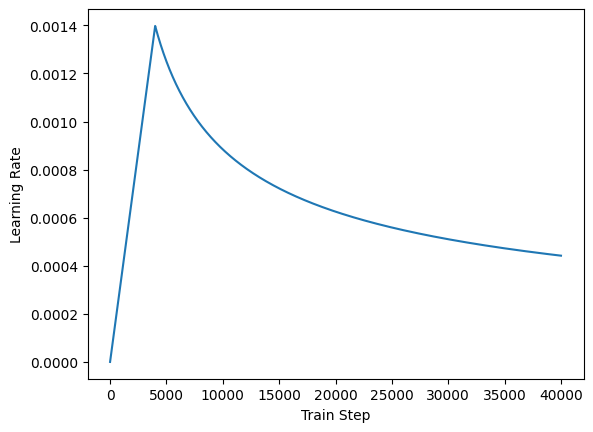

In [112]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [113]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [114]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)



def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)


In [115]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

In [116]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate
)


In [117]:
#checkpoint_path = "/home/oem/KYM/자연어 데이터 실험/활성함수 관련 트랜스포머/base/train"
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [118]:
EPOCHS = 100

In [119]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

# Define the input signature with initial_a and initial_b as tf.TensorSpec
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # Input tensor
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # Target tensor
    tf.TensorSpec(shape=(), dtype=tf.float32),           # initial_a
    tf.TensorSpec(shape=(), dtype=tf.float32)            # initial_b
]

@tf.function
def train_step(inp, tar, initial_a, initial_b):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],
                                     training=True)
        loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        train_loss(loss)
        train_accuracy(accuracy_function(tar_real, predictions))
        
@tf.function
def val_step(inp, tar, initial_a, initial_b):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    predictions, _ = transformer([inp, tar_inp], training=False)
    loss = loss_function(tar_real, predictions)

    val_loss(loss)
    val_accuracy(accuracy_function(tar_real, predictions))


In [120]:
# Define the list of values to iterate over
# 리스트에 여러 값을 넣을 시 반복할 때 알 수 없는 오류가 발생함.
initial_a_values = [6.0]
initial_b_values = [0.0]

In [121]:
for initial_a in initial_a_values:
    for initial_b in initial_b_values:
        print(f"Training with initial_a={initial_a} and initial_b={initial_b}")

        # Initialize the transformer model with the new initial_a and initial_b values
        transformer = Transformer(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
            target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
            pe_input=1000,
            pe_target=1000,
            rate=dropout_rate,
            initial_a=initial_a,
            initial_b=initial_b
        )

        # Initialize lists to store results for the current combination of initial_a and initial_b
        train_loss_results = []
        train_accuracy_results = []
        val_loss_results = []
        val_accuracy_results = []

        for epoch in range(EPOCHS):
            start = time.time()

            # Reset metrics at the beginning of each epoch
            train_loss.reset_state()
            train_accuracy.reset_state()
            val_loss.reset_state()
            val_accuracy.reset_state()

            for (batch, (inp, tar)) in enumerate(train_batches):
                train_step(inp, tar, initial_a, initial_b)

                if batch % 50 == 0:
                    print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

            for (batch, (inp, tar)) in enumerate(val_batches):
                val_step(inp, tar, initial_a, initial_b)

            if (epoch + 1) % 5 == 0:
                ckpt_save_path = ckpt_manager.save()
                print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

            # Record results for the current epoch
            train_loss_results.append(train_loss.result().numpy())
            train_accuracy_results.append(train_accuracy.result().numpy())
            val_loss_results.append(val_loss.result().numpy())
            val_accuracy_results.append(val_accuracy.result().numpy())

            print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} Val Loss {val_loss.result():.4f} Val Accuracy {val_accuracy.result():.4f}')
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

        # Save results to a CSV file
        df = pd.DataFrame({
            'Train Loss': train_loss_results,
            'Train Accuracy': train_accuracy_results,
            'Validation Loss': val_loss_results,
            'Validation Accuracy': val_accuracy_results
        })

        # Create a CSV file name based on initial_a and initial_b
        csv_file_path = f'a{initial_a}_b{initial_b}.csv'
        df.to_csv(csv_file_path, index=False)

        print(f"Data saved to {csv_file_path}")


Training with initial_a=6.0 and initial_b=0.0
Epoch 1 Batch 0 Loss 8.8718 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.9123 Accuracy 0.0392
Epoch 1 Batch 100 Loss 7.2185 Accuracy 0.0424
Epoch 1 Loss 7.2079 Accuracy 0.0425 Val Loss 6.2081 Val Accuracy 0.0492
Time taken for 1 epoch: 612.28 secs

Epoch 2 Batch 0 Loss 6.2539 Accuracy 0.0520
Epoch 2 Batch 50 Loss 6.2173 Accuracy 0.0601
Epoch 2 Batch 100 Loss 6.1820 Accuracy 0.0744
Epoch 2 Loss 6.1806 Accuracy 0.0748 Val Loss 6.0121 Val Accuracy 0.1356
Time taken for 1 epoch: 394.11 secs

Epoch 3 Batch 0 Loss 6.0746 Accuracy 0.1198
Epoch 3 Batch 50 Loss 5.9704 Accuracy 0.1291
Epoch 3 Batch 100 Loss 5.8544 Accuracy 0.1393
Epoch 3 Loss 5.8542 Accuracy 0.1394 Val Loss 5.5750 Val Accuracy 0.1809
Time taken for 1 epoch: 315.58 secs

Epoch 4 Batch 0 Loss 5.6687 Accuracy 0.1687
Epoch 4 Batch 50 Loss 5.5192 Accuracy 0.1830
Epoch 4 Batch 100 Loss 5.4303 Accuracy 0.1897
Epoch 4 Loss 5.4293 Accuracy 0.1897 Val Loss 5.2359 Val Accuracy 0.2050
Time taken for 

Epoch 32 Loss 3.2718 Accuracy 0.4182 Val Loss 3.2307 Val Accuracy 0.4541
Time taken for 1 epoch: 129.85 secs

Epoch 33 Batch 0 Loss 3.2344 Accuracy 0.4187
Epoch 33 Batch 50 Loss 3.2388 Accuracy 0.4224
Epoch 33 Batch 100 Loss 3.2289 Accuracy 0.4237
Epoch 33 Loss 3.2279 Accuracy 0.4238 Val Loss 3.2233 Val Accuracy 0.4497
Time taken for 1 epoch: 158.33 secs

Epoch 34 Batch 0 Loss 3.1840 Accuracy 0.4261
Epoch 34 Batch 50 Loss 3.2012 Accuracy 0.4263
Epoch 34 Batch 100 Loss 3.1923 Accuracy 0.4276
Epoch 34 Loss 3.1914 Accuracy 0.4278 Val Loss 3.1547 Val Accuracy 0.4618
Time taken for 1 epoch: 91.61 secs

Epoch 35 Batch 0 Loss 3.2100 Accuracy 0.4266
Epoch 35 Batch 50 Loss 3.1649 Accuracy 0.4309
Epoch 35 Batch 100 Loss 3.1582 Accuracy 0.4318
Saving checkpoint for epoch 35 at ./checkpoints/train/ckpt-151
Epoch 35 Loss 3.1573 Accuracy 0.4318 Val Loss 3.1133 Val Accuracy 0.4691
Time taken for 1 epoch: 122.12 secs

Epoch 36 Batch 0 Loss 3.1465 Accuracy 0.4309
Epoch 36 Batch 50 Loss 3.1199 Accuracy 

Epoch 64 Batch 50 Loss 2.4591 Accuracy 0.5249
Epoch 64 Batch 100 Loss 2.4630 Accuracy 0.5248
Epoch 64 Loss 2.4613 Accuracy 0.5249 Val Loss 2.7240 Val Accuracy 0.5333
Time taken for 1 epoch: 91.19 secs

Epoch 65 Batch 0 Loss 2.4071 Accuracy 0.5345
Epoch 65 Batch 50 Loss 2.4516 Accuracy 0.5255
Epoch 65 Batch 100 Loss 2.4467 Accuracy 0.5266
Saving checkpoint for epoch 65 at ./checkpoints/train/ckpt-157
Epoch 65 Loss 2.4471 Accuracy 0.5267 Val Loss 2.7141 Val Accuracy 0.5320
Time taken for 1 epoch: 83.44 secs

Epoch 66 Batch 0 Loss 2.4579 Accuracy 0.5234
Epoch 66 Batch 50 Loss 2.4327 Accuracy 0.5288
Epoch 66 Batch 100 Loss 2.4338 Accuracy 0.5292
Epoch 66 Loss 2.4325 Accuracy 0.5294 Val Loss 2.6222 Val Accuracy 0.5457
Time taken for 1 epoch: 70.95 secs

Epoch 67 Batch 0 Loss 2.3815 Accuracy 0.5398
Epoch 67 Batch 50 Loss 2.4141 Accuracy 0.5311
Epoch 67 Batch 100 Loss 2.4172 Accuracy 0.5310
Epoch 67 Loss 2.4174 Accuracy 0.5310 Val Loss 2.7186 Val Accuracy 0.5348
Time taken for 1 epoch: 67.68 

Epoch 96 Batch 0 Loss 2.0017 Accuracy 0.5876
Epoch 96 Batch 50 Loss 2.0715 Accuracy 0.5791
Epoch 96 Batch 100 Loss 2.0734 Accuracy 0.5787
Epoch 96 Loss 2.0752 Accuracy 0.5784 Val Loss 2.6039 Val Accuracy 0.5587
Time taken for 1 epoch: 70.59 secs

Epoch 97 Batch 0 Loss 2.0366 Accuracy 0.5856
Epoch 97 Batch 50 Loss 2.0673 Accuracy 0.5795
Epoch 97 Batch 100 Loss 2.0637 Accuracy 0.5799
Epoch 97 Loss 2.0646 Accuracy 0.5798 Val Loss 2.6284 Val Accuracy 0.5514
Time taken for 1 epoch: 68.27 secs

Epoch 98 Batch 0 Loss 2.0427 Accuracy 0.5773
Epoch 98 Batch 50 Loss 2.0497 Accuracy 0.5818
Epoch 98 Batch 100 Loss 2.0556 Accuracy 0.5811
Epoch 98 Loss 2.0549 Accuracy 0.5811 Val Loss 2.5676 Val Accuracy 0.5608
Time taken for 1 epoch: 78.67 secs

Epoch 99 Batch 0 Loss 2.0560 Accuracy 0.5783
Epoch 99 Batch 50 Loss 2.0433 Accuracy 0.5830
Epoch 99 Batch 100 Loss 2.0440 Accuracy 0.5827
Epoch 99 Loss 2.0449 Accuracy 0.5826 Val Loss 2.6042 Val Accuracy 0.5570
Time taken for 1 epoch: 61.35 secs

Epoch 100 Ba

### 결과 그래프

In [124]:
import os
import pandas as pd

directory_path = "result-para"

column_names_list = []

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        column_names = df.columns.tolist()
        column_names_list.append({filename: column_names})

for result in column_names_list:
    print(result)

{'a5.0_b0.0.csv': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']}
{'a4.0_b0.0.csv': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']}
{'a1.0_b0.0.csv': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']}
{'a3.0_b0.0.csv': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']}
{'a2.0_b0.0.csv': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']}
{'relu_parsed.csv': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']}
{'a6.0_b0.0.csv': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']}


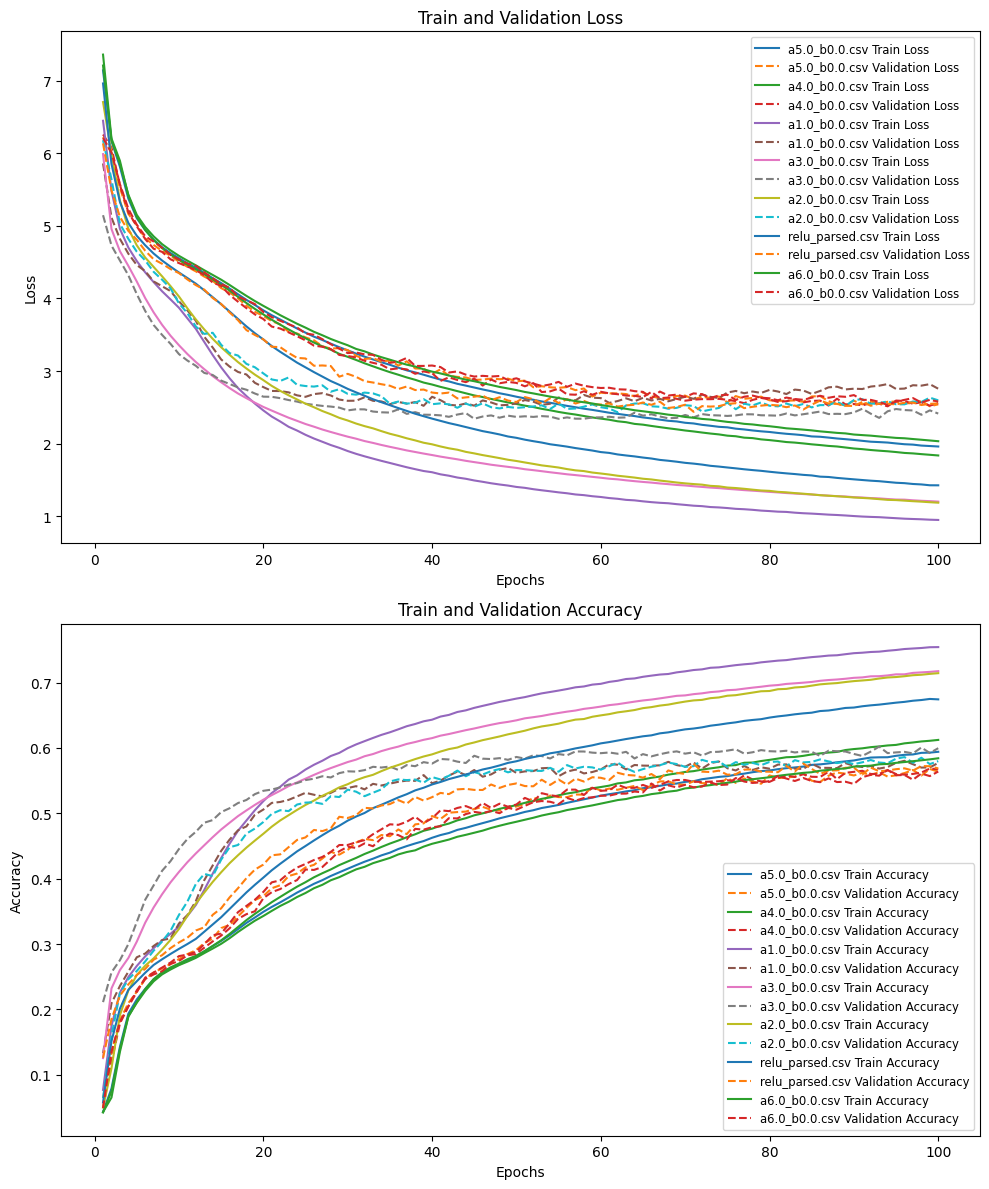

In [127]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

def parse_tensor(tensor_str):
    """Extracts the numerical value from a tf.Tensor string."""
    match = re.search(r'tf\.Tensor\(([\d\.]+),', tensor_str)
    if match:
        return float(match.group(1))
    raise ValueError(f"Unexpected tensor format: {tensor_str}")

directory_path = "result-para"

plt.figure(figsize=(10, 12))

# Train and Validation Loss
plt.subplot(2, 1, 1)  # 2행 1열의 첫 번째 그래프
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Train and Validation Accuracy
plt.subplot(2, 1, 2) 
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# 디렉토리 내 모든 파일을 순회
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        
        df = pd.read_csv(file_path)

        # 데이터 전처리: tf.Tensor 형식 처리
        for column in df.columns:
            if df[column].dtype == object:  # 문자열 열인지 확인
                df[column] = df[column].apply(lambda x: parse_tensor(x) if 'tf.Tensor' in x else x)
        
        # Epochs (인덱스를 1부터 시작하게 수정)
        epochs = range(1, len(df) + 1)
        
        plt.subplot(2, 1, 1)
        plt.plot(epochs, df['Train Loss'], label=f'{filename} Train Loss')
        plt.plot(epochs, df['Validation Loss'], label=f'{filename} Validation Loss', linestyle='--')

        plt.subplot(2, 1, 2)
        plt.plot(epochs, df['Train Accuracy'], label=f'{filename} Train Accuracy')
        plt.plot(epochs, df['Validation Accuracy'], label=f'{filename} Validation Accuracy', linestyle='--')

plt.subplot(2, 1, 1)
plt.legend(loc='best', fontsize='small')

plt.subplot(2, 1, 2)
plt.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()
